In [2]:
import numpy as np
from pathlib import Path
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from scipy.interpolate import RegularGridInterpolator
from scipy import sparse
from scipy.sparse.linalg import spsolve
from trainer import *
from models import *
from utils import *

levels1 = [-500, -750, -1000, -1500, -2000, -2500, -3000][::-1]
levels2 = [-0.02, -0.05,-0.08, -0.1, -0.15, -0.2, -0.25, -0.3][::-1]
def normal1(x, y, h, mean=[0, 0]):
    var = np.diag([1] * 2) * h**2 / (2 * np.pi)
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, var)
    return rv.pdf(pos)

In [3]:
def testQs(model, ckpt_path, data_path, N, Qs, four = False, levels=None, a=1, boundary_type='D', numerical_method='fd'):
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()
    A = sparse.load_npz(f'{data_path}{numerical_method}_A{boundary_type}.npz').tocsc()
    Qs = Qs.reshape(-1, 1, 1)
    if numerical_method == 'fd':
        h = 2*a / (N-1)
        x = np.linspace(-a, a, N)
        y = np.linspace(-a, a, N)
        xx, yy = np.meshgrid(x, y)
        f_mat = normal(xx, yy, h) if not four else normal_fourth(xx, yy, h)
        
        f_mat = f_mat.reshape(1, N, N)
        data = Qs * f_mat
        B = (data * h**2).reshape(-1, N**2)
    elif numerical_method == 'fv':
        h = 2*a / (N-1)
        l, r = -a+h/2, a-h/2
        x = np.linspace(l, r, N)
        y = np.linspace(l, r, N)
        xx, yy = np.meshgrid(x, y)
        f_mat = np.zeros_like(xx)
        if not four:
            idx = int(-l//h) + 1
            f_mat[idx, idx] = 1
        else:
            idx = int((-a/2 - l)//h) + 1
            idy = int(( a/2 - l)//h) + 1
            f_mat[idx, idx] = f_mat[idx, idy] = f_mat[idy, idx] = f_mat[idy, idy] = 1
        f_mat = f_mat.reshape(1, N, N)
        data = Qs * f_mat
        B = data.reshape(-1, N**2)

    nums = data.shape[0]
    for idx in range(nums):
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(30)
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        arr = np.stack((xx, yy, data[idx]), axis=0)
        arr = arr[np.newaxis, ...]
        
        tensor = torch.from_numpy(arr).to(torch.float32)
        b = B[idx].squeeze()

        pre = model.padder(model(tensor))
        pre = pre.numpy().squeeze()
        ans = spsolve(A, B[idx]).reshape(N, N)
#         ans = ans[1:-1, 1:-1]
        X, Y = xx, yy

        q = Qs.item(idx)
        diff = np.abs(pre - ans)
        surf_pre = ax1.plot_surface(X, Y, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax1.set_title(f'$Pre Q={q:.2f}$', fontsize=20)
        plt.colorbar(surf_pre, ax=ax1, shrink=0.8)

        im = ax2.imshow(diff, cmap='jet')   
        plt.colorbar(im, ax=ax2, shrink=0.8)
        ax2.set_title(f'$L2 Norm:{(diff*h**2).sum():.2e}$', fontsize=20)

        ct1 = ax3.contour(X, Y, pre, colors='b', linewidths=2, levels=levels)
        ct2 = ax3.contour(X, Y, ans, colors='r', linewidths=3, linestyles='solid', levels=levels)
        ax3.clabel(ct1, inline=True, fontsize=20)
        ax3.clabel(ct2, inline=True, fontsize=20)
        h1, _ = ct1.legend_elements()
        h2, _ = ct2.legend_elements()
        ax3.legend([h1[0], h2[0]], ['NN', 'Numerical'],  fontsize='medium')
        fig.tight_layout()
    return True

bd = 'D'
N = 65
a = 1
h = 2*a / N
data_type='One'
backward_type = 'cg'
numerical_method = 'fv'
features = 32
batch_size = 32
data_path = f'../data/{N}/'

model = LAModel(net = UNet(features=features, boundary_type=bd, numerical_method=numerical_method), 
                data_path=f'../data/{N}/mat/', boundary_type=bd, h=h, numerical_method=numerical_method)
Qs = [6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 23333, 24000] if 'Big' in data_type else [0.62, 0.74, 0.88, 0.96, 1.23, 1.45, 1.67, 1.92, 2.12, 2.34, 2.56, 2.73]
Qs = np.array(Qs)
# Qs = np.linspace(1, 2, 10)
# func = normal_fourth if 'Four' in datatype else normal
testQs(model, f'../lightning_logs/{numerical_method}_{backward_type}_{N}_UNet_{features}_bs{batch_size}_{data_type}{bd}/version_1/checkpoints/last.ckpt', 
       f'../data/{N}/mat/', N, Qs, False, levels2, a, bd, numerical_method)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

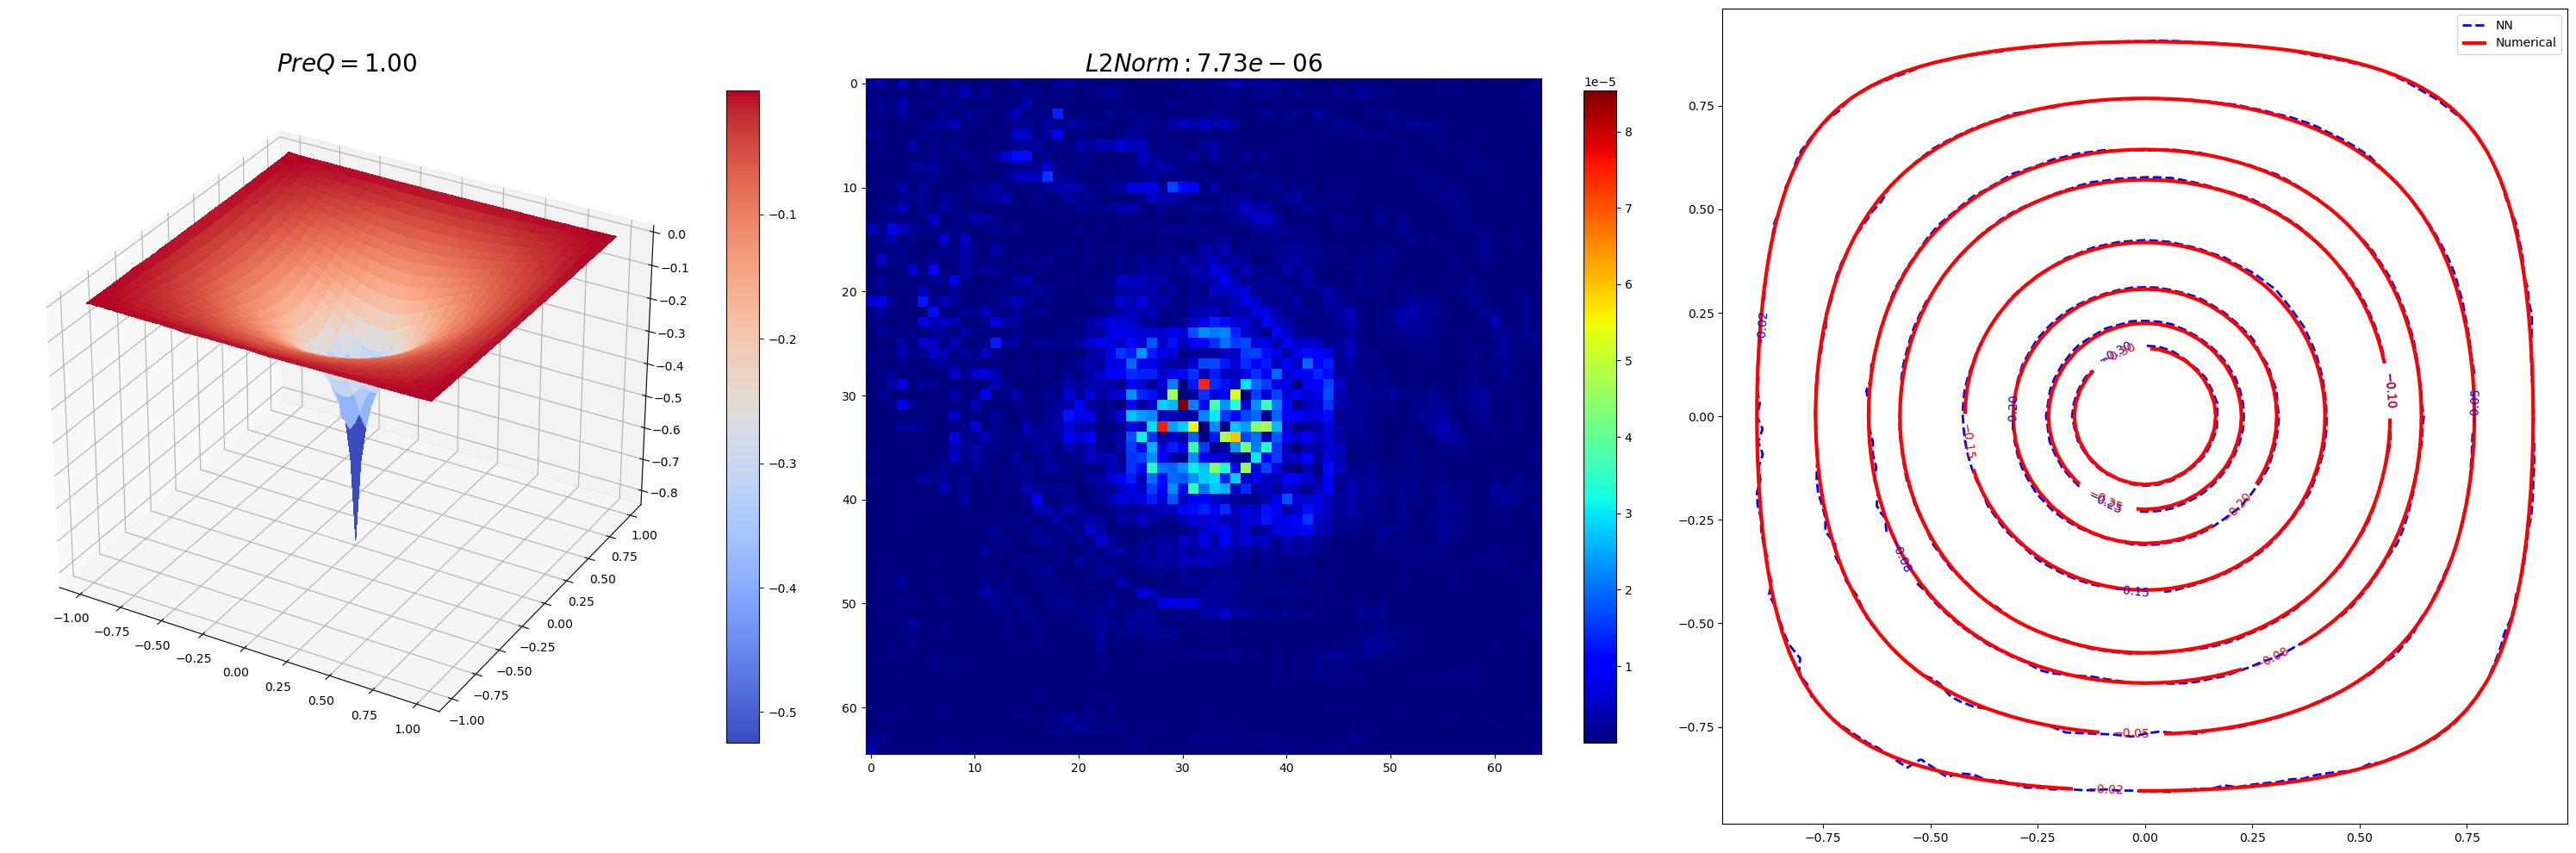

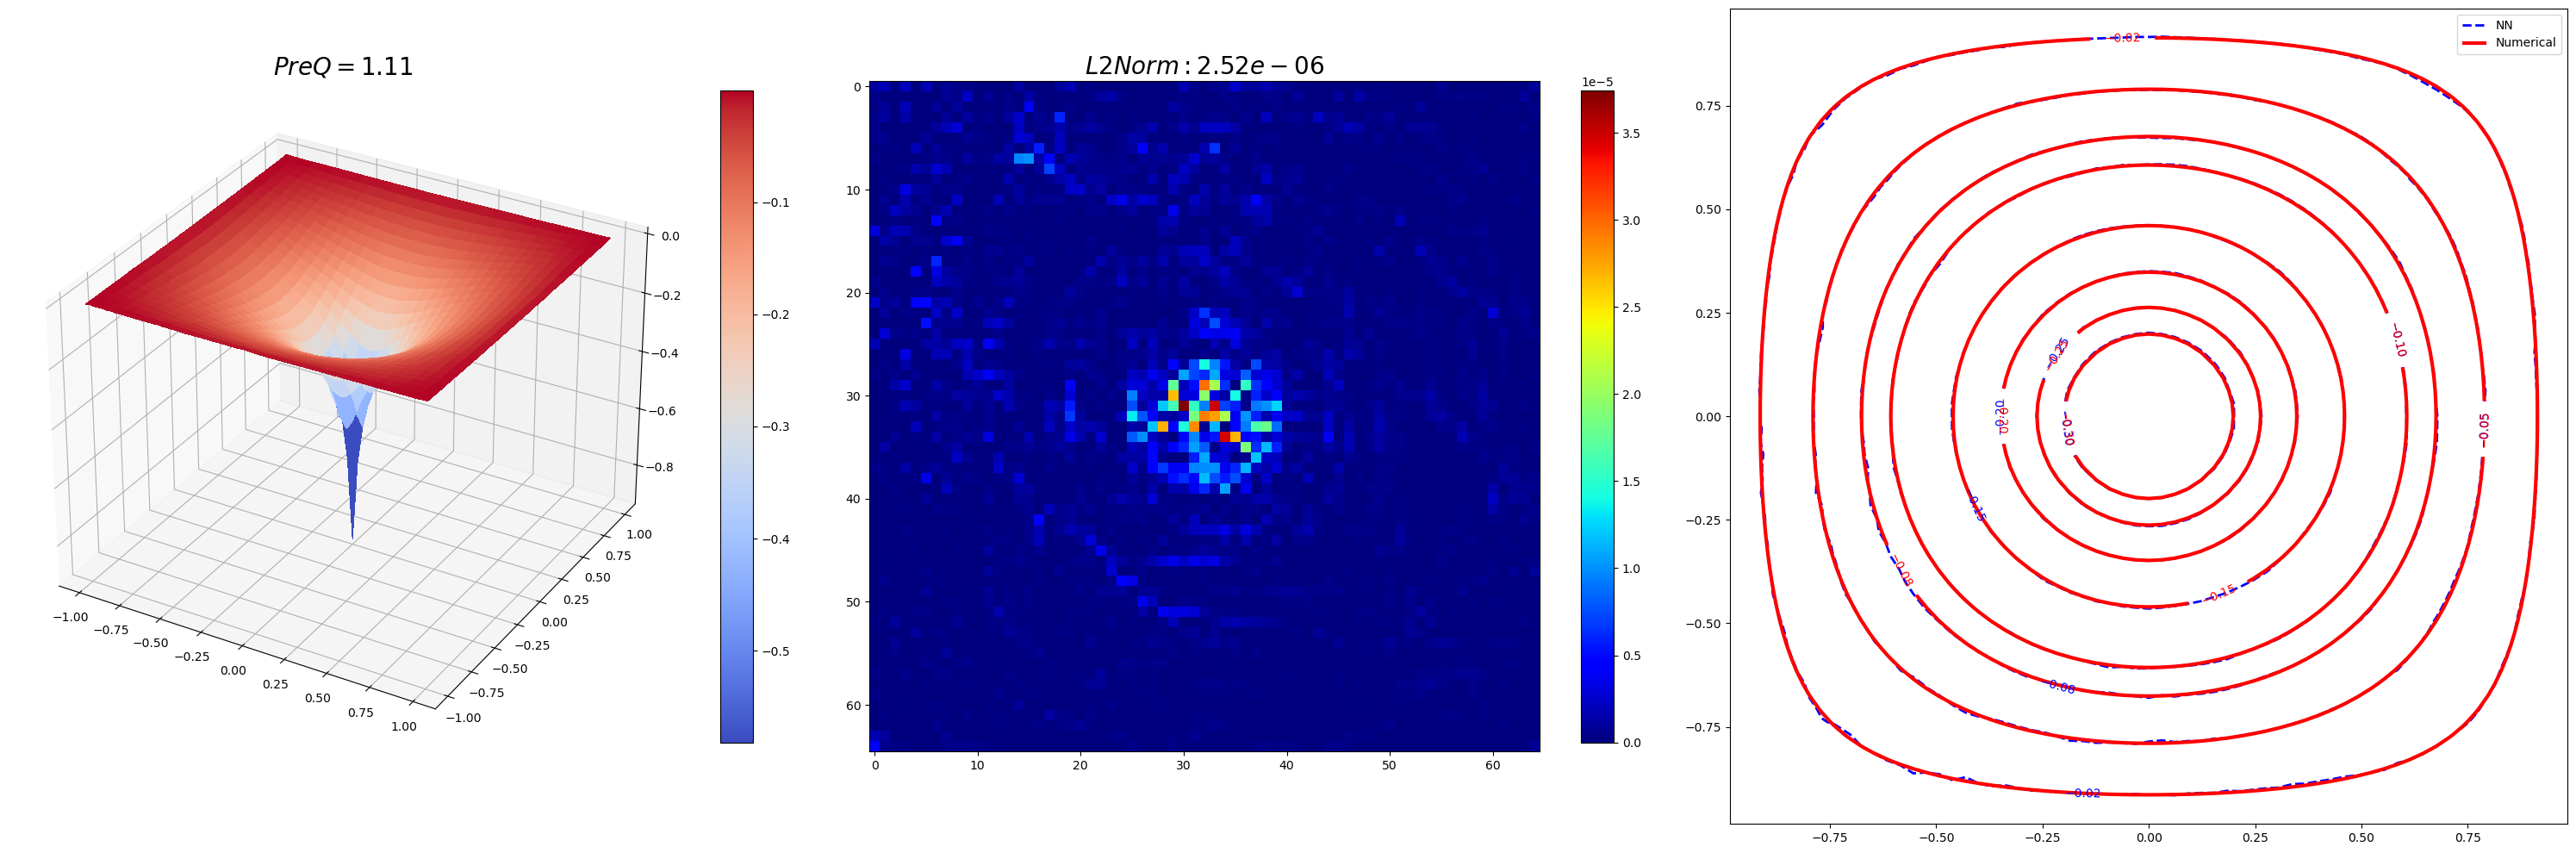

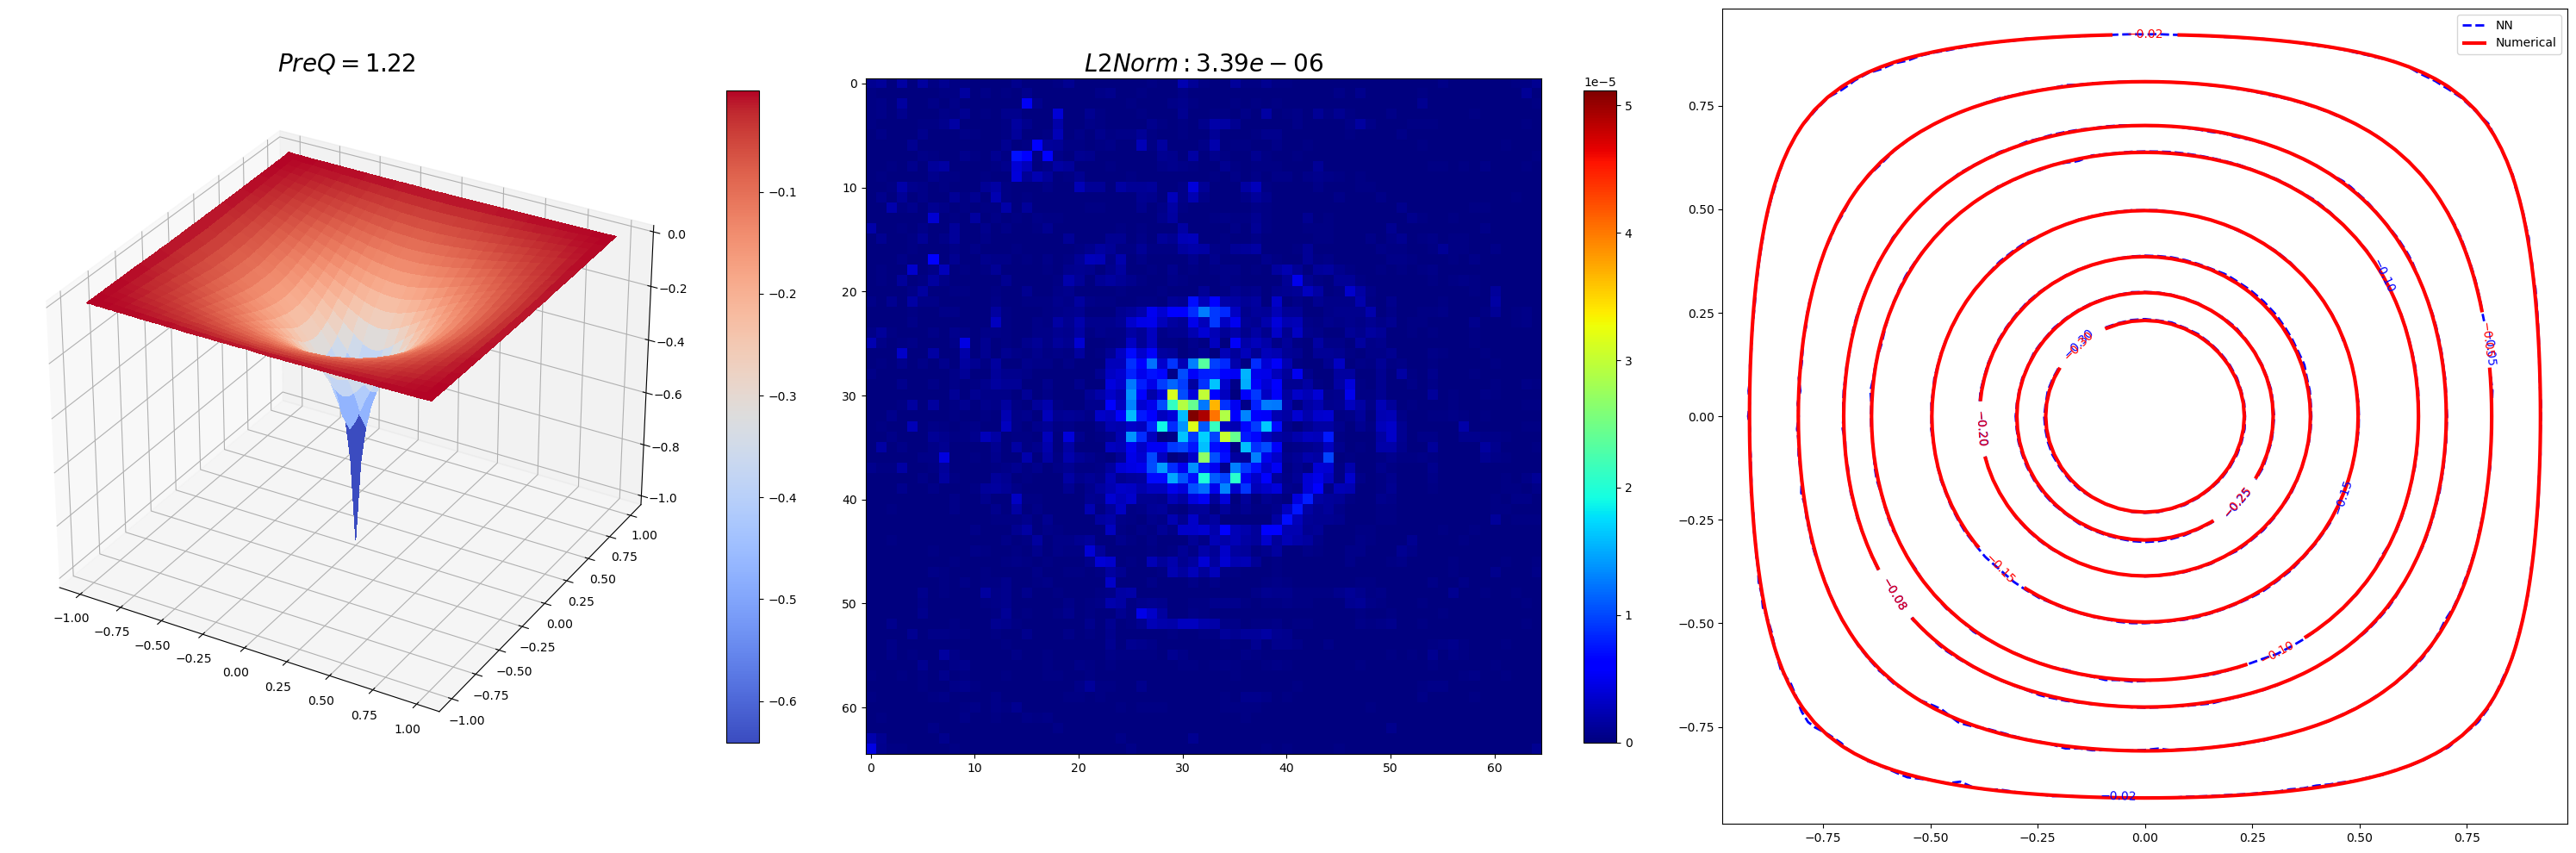

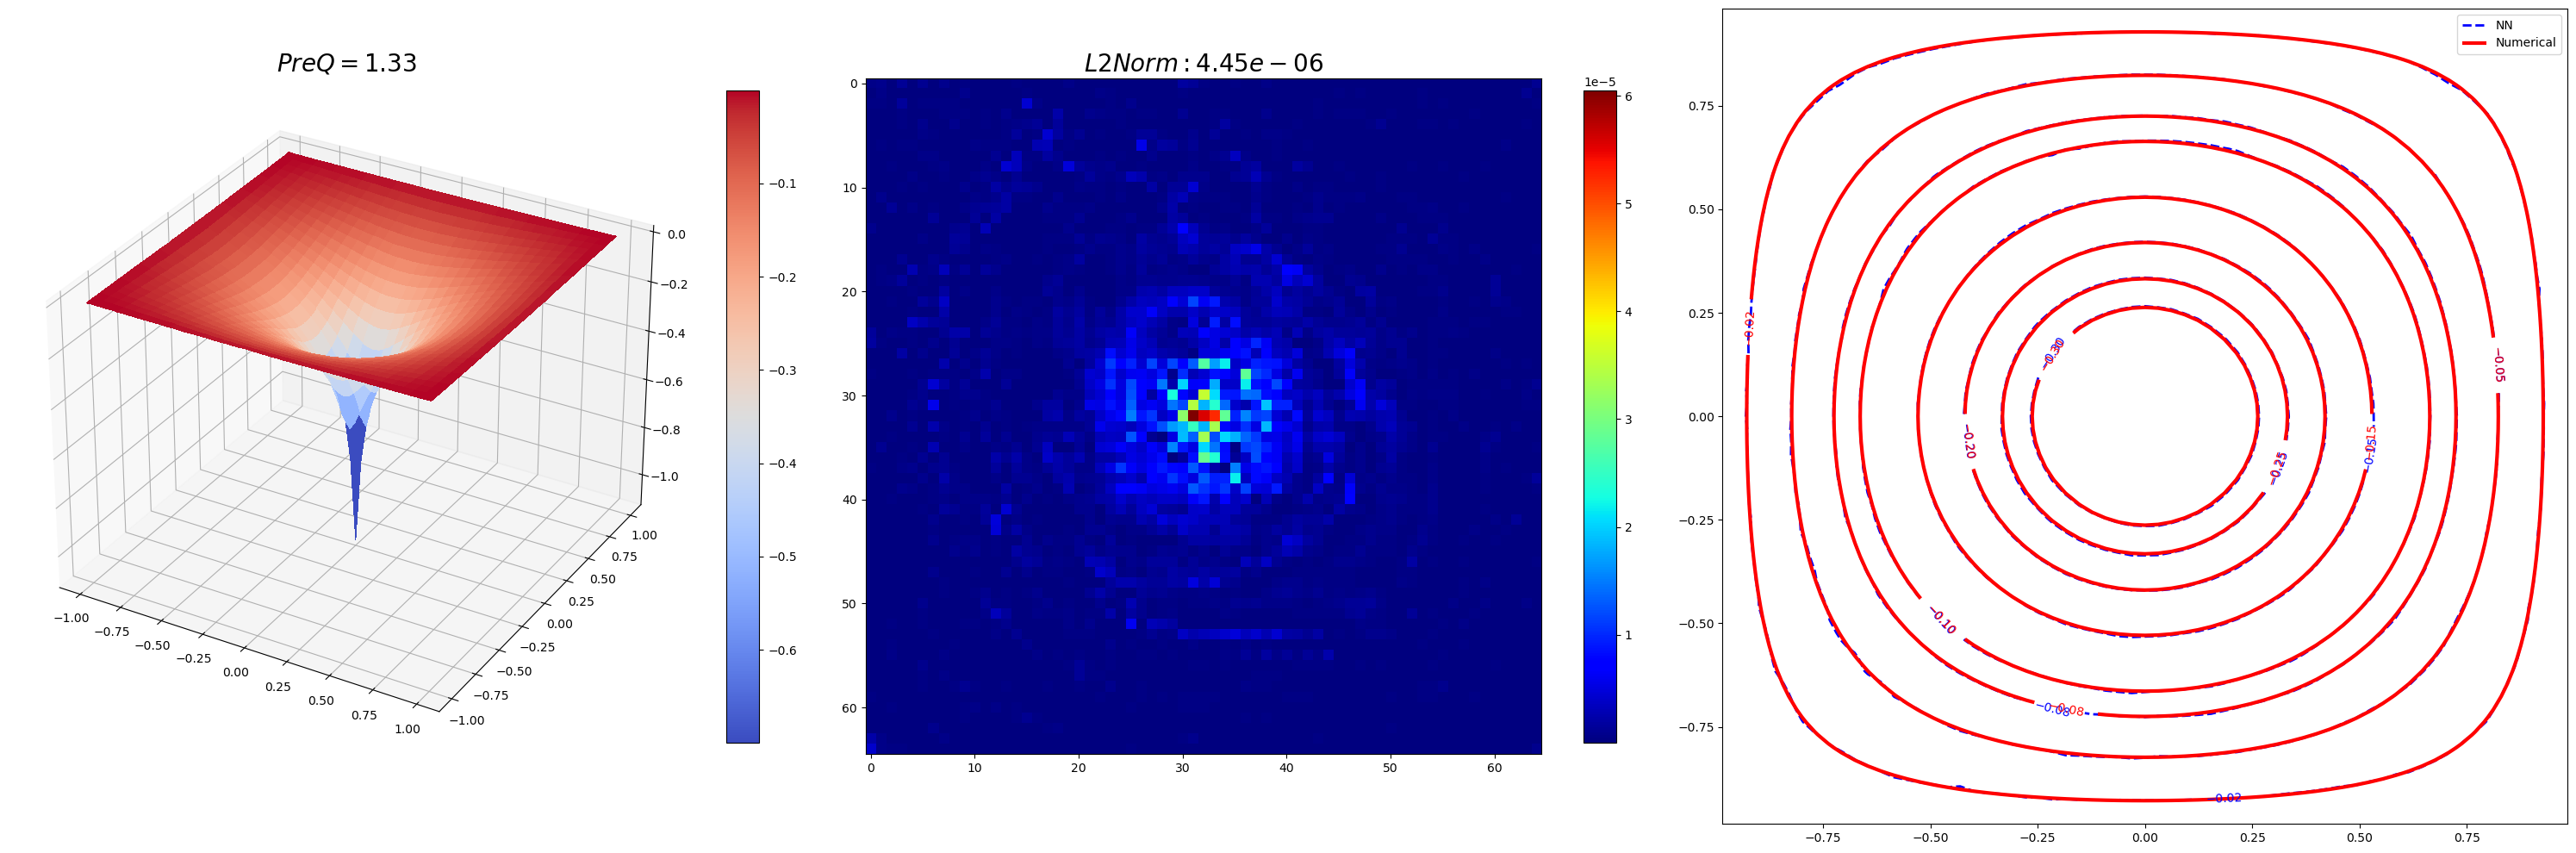

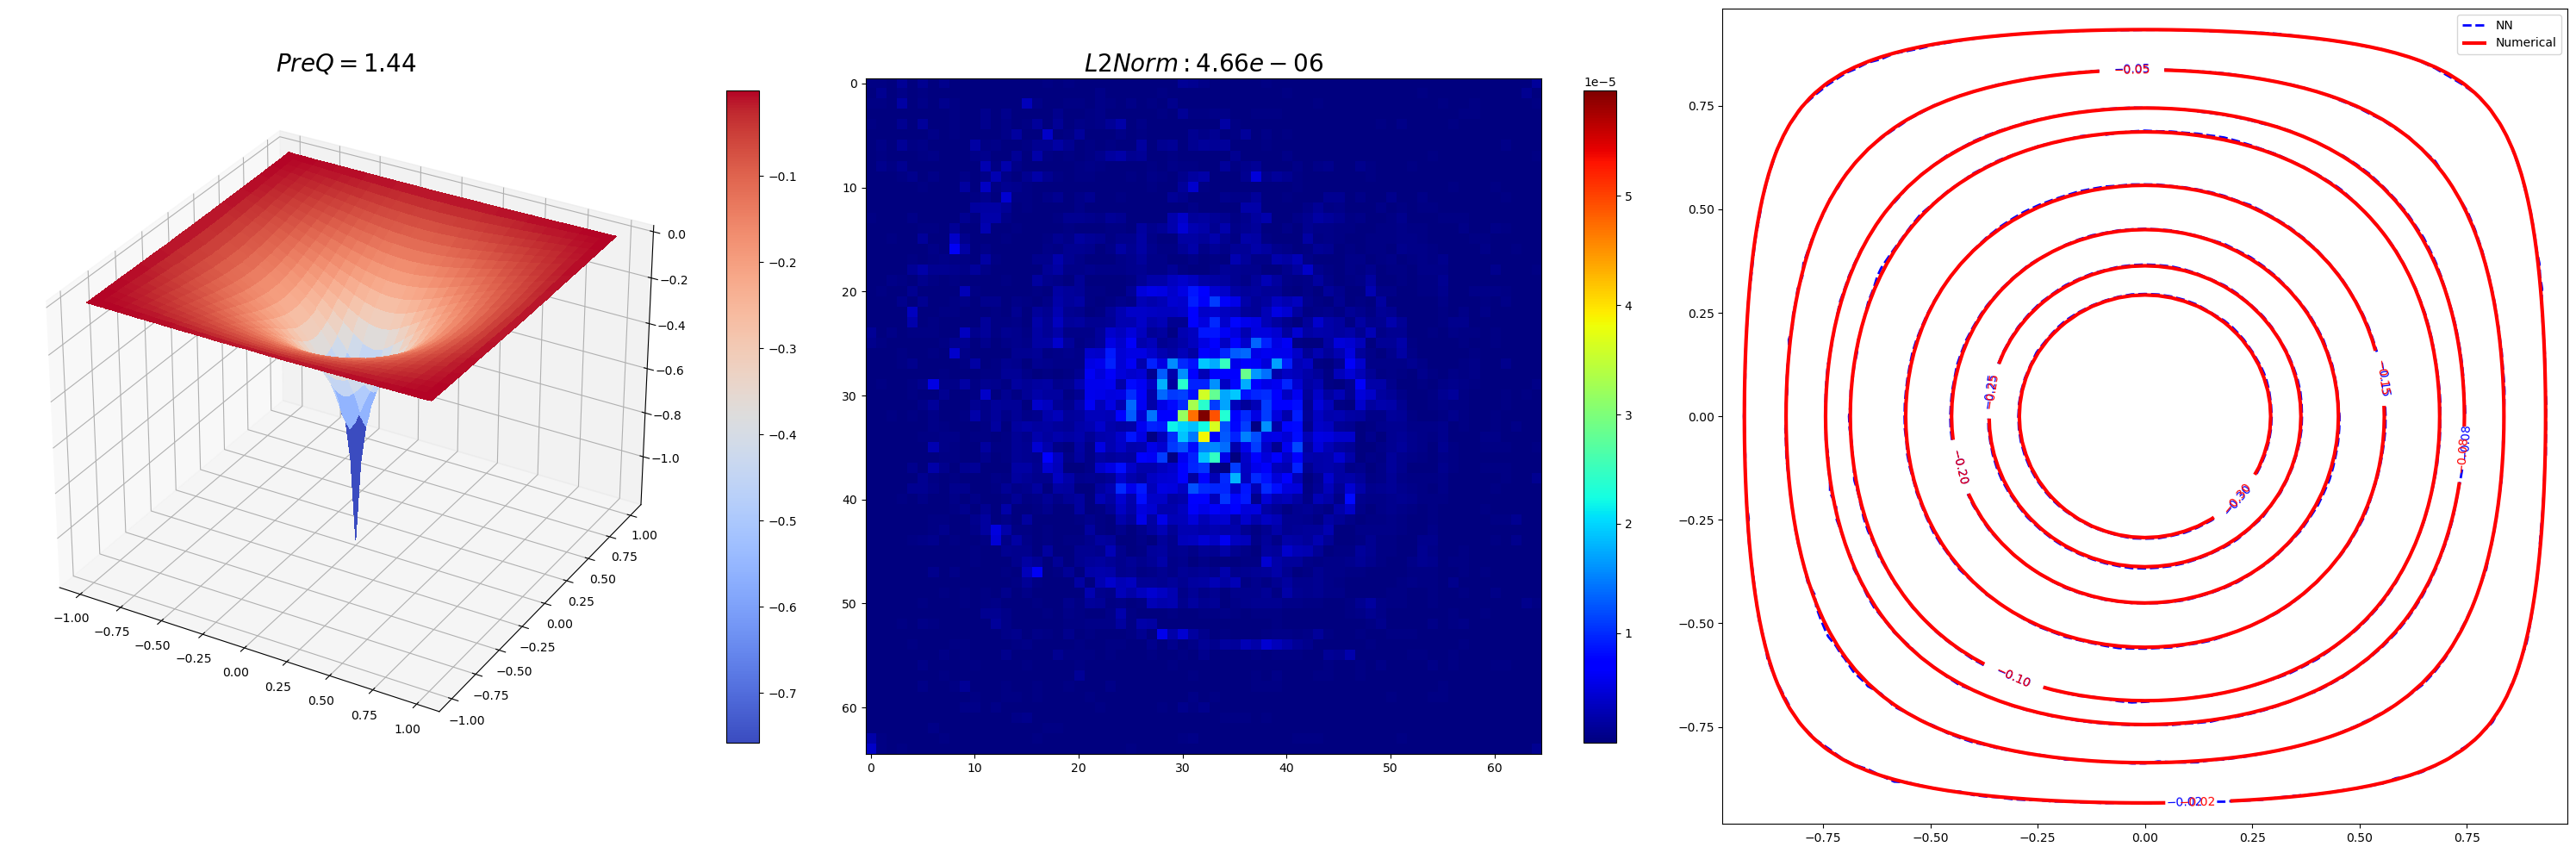

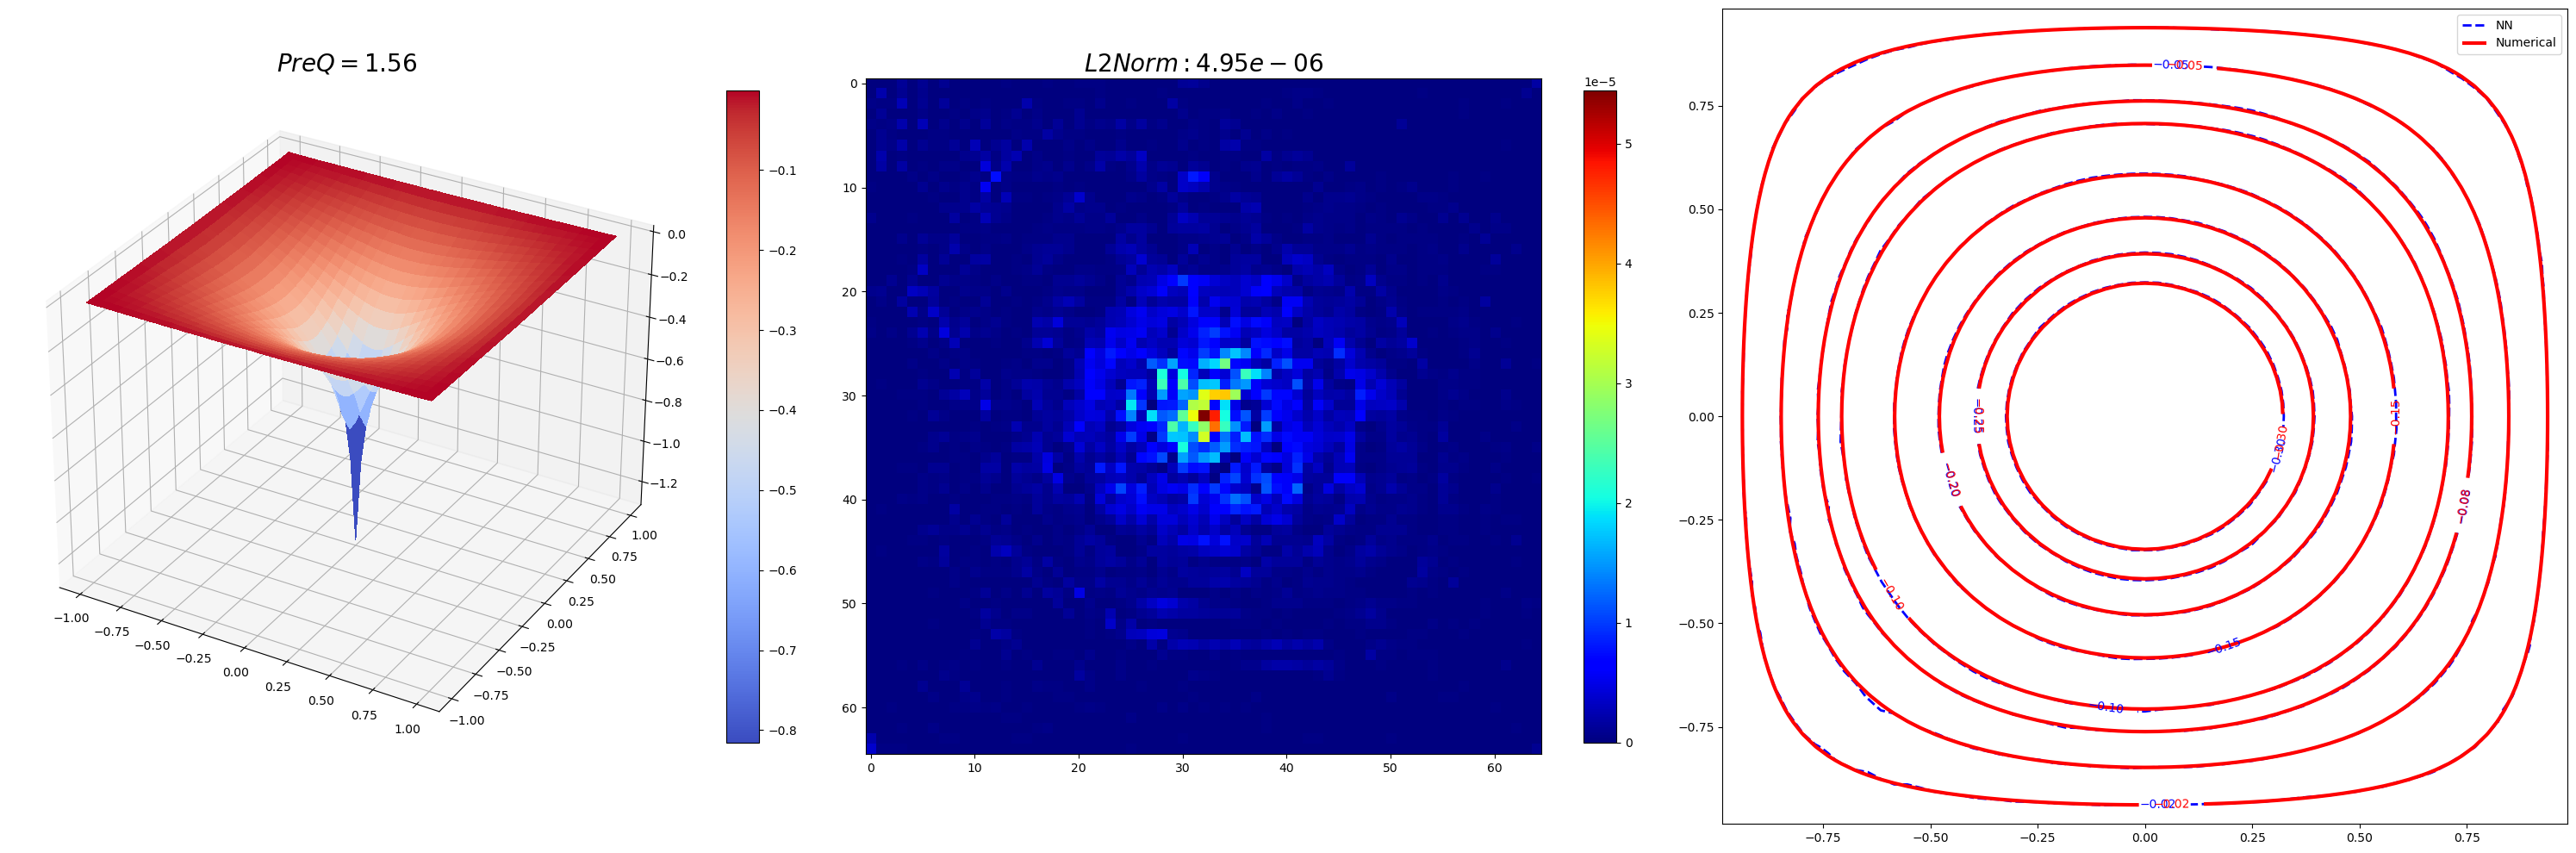

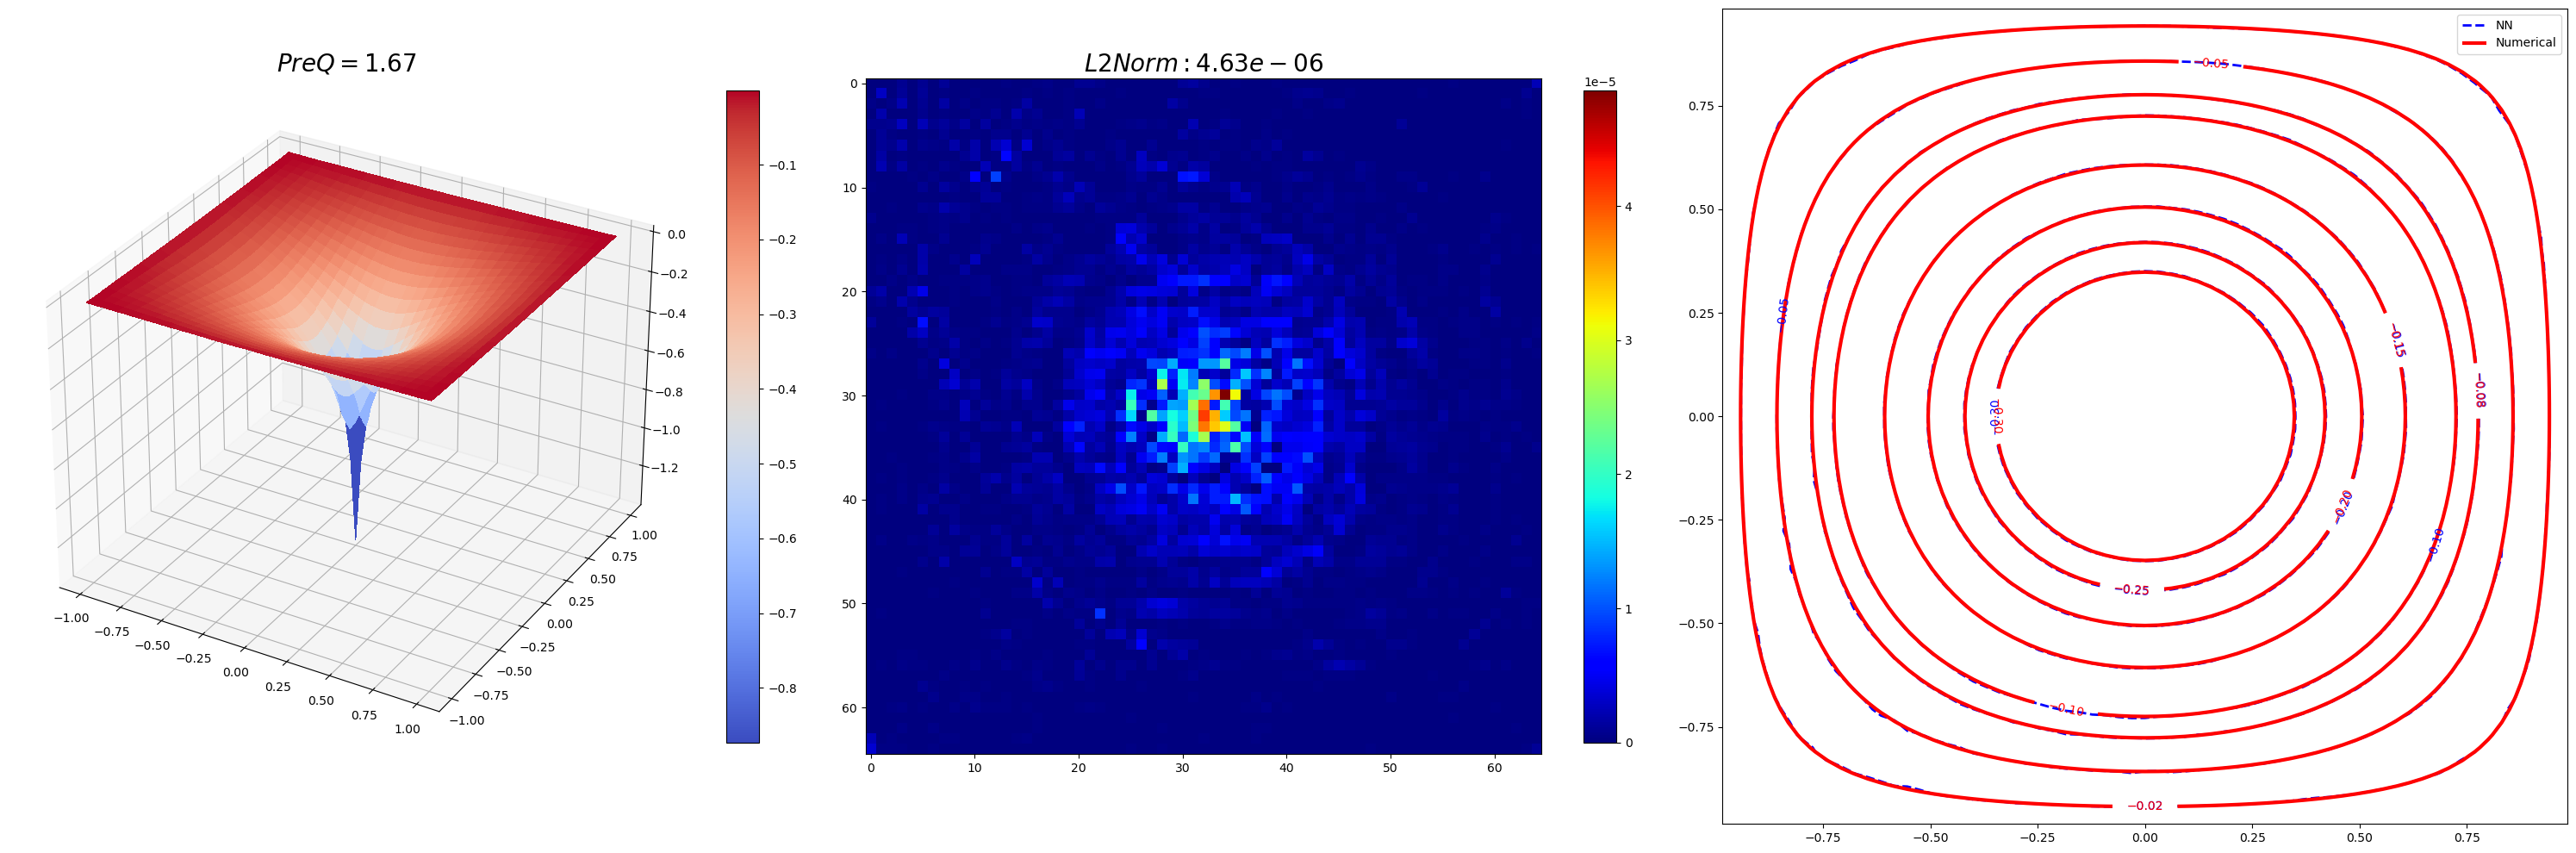

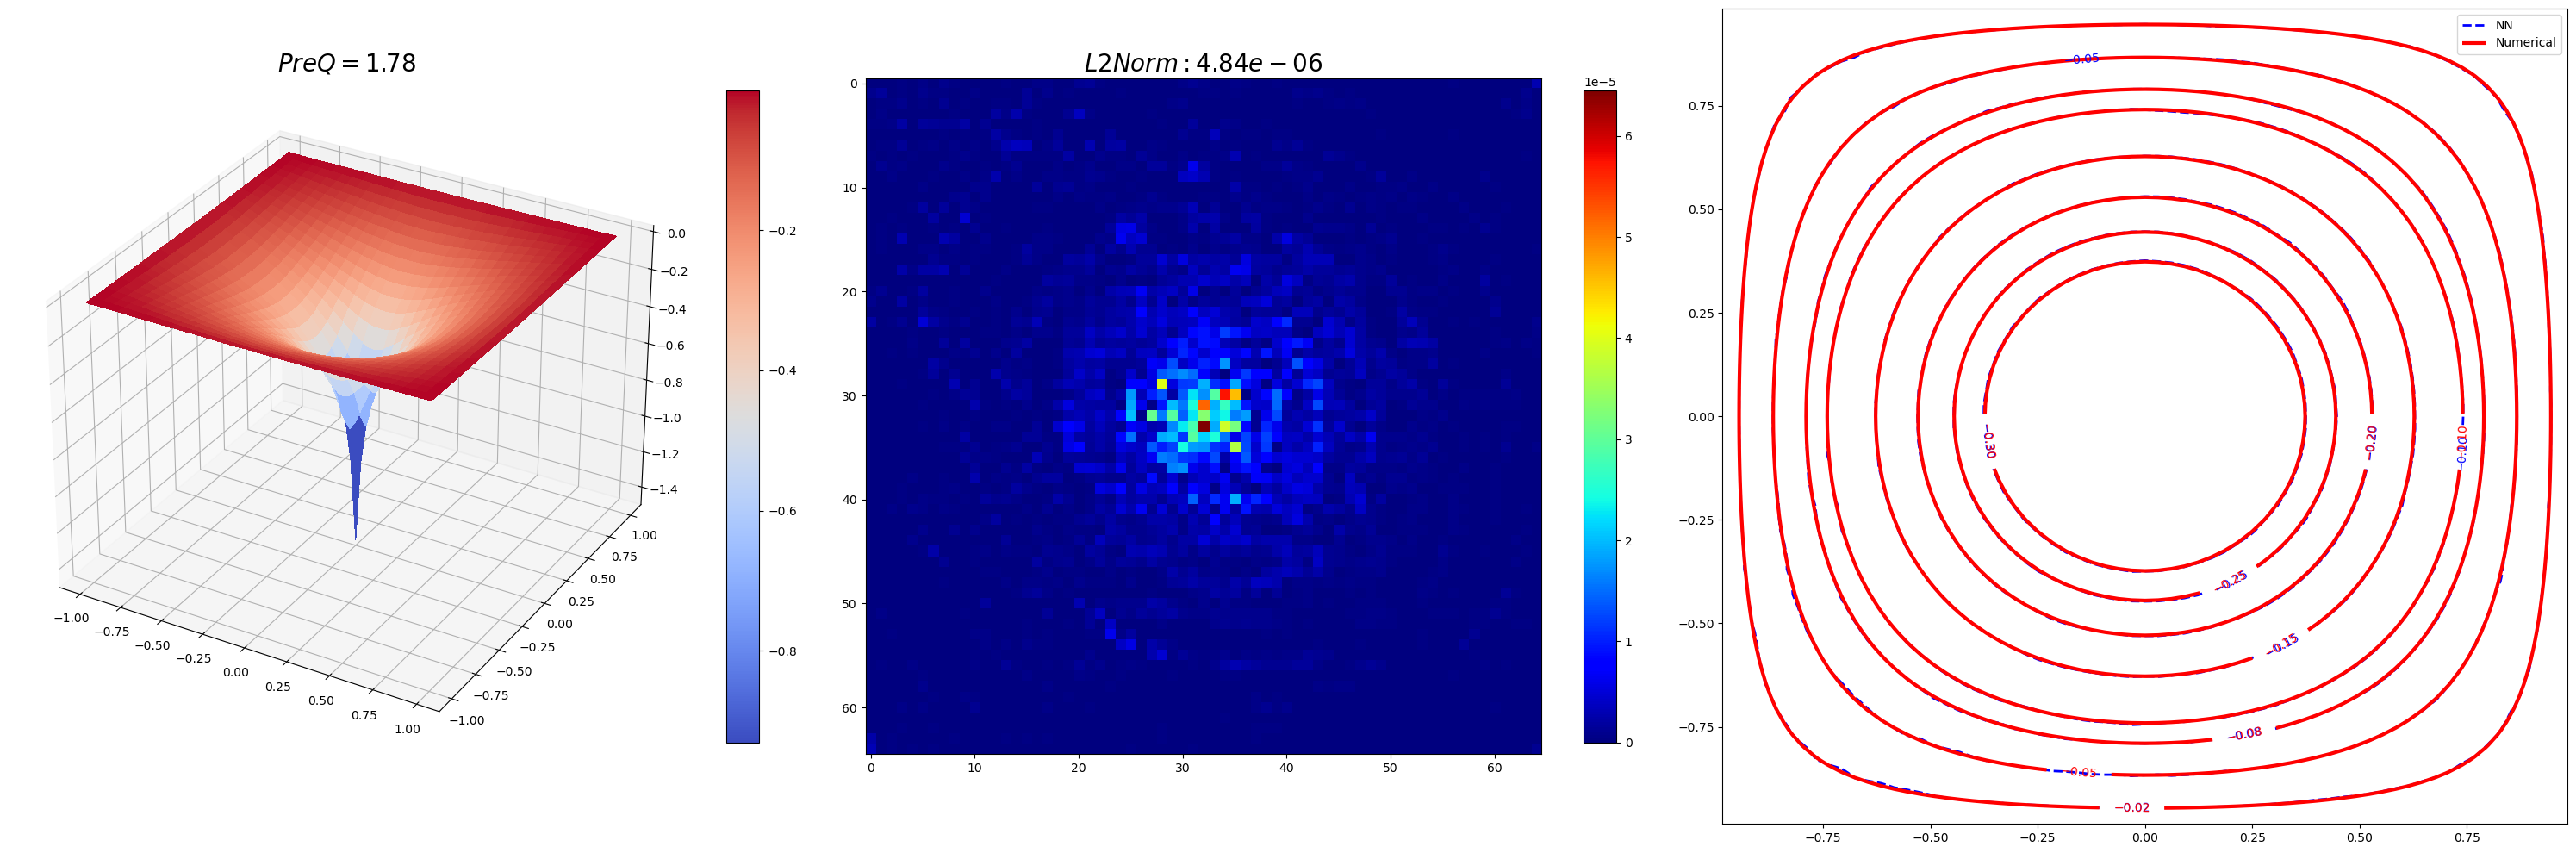

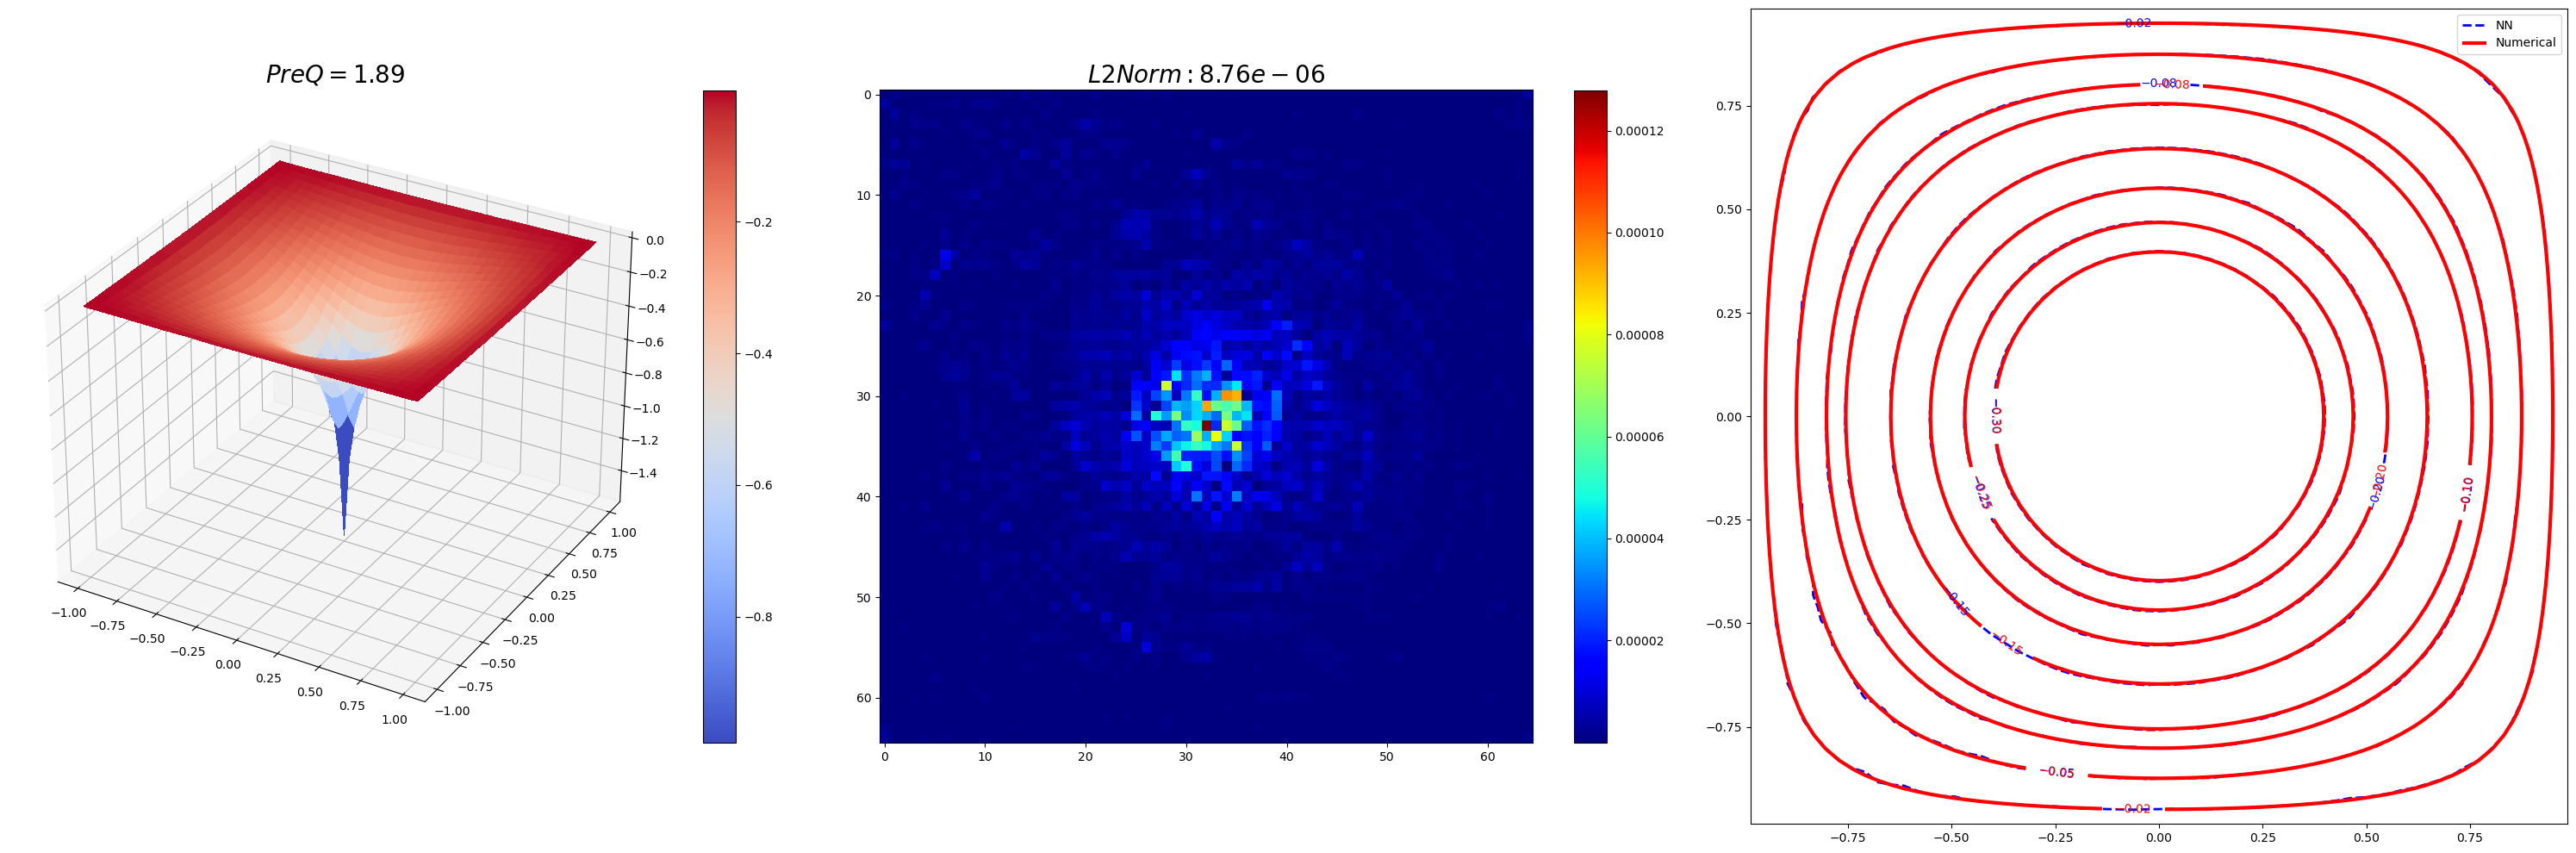

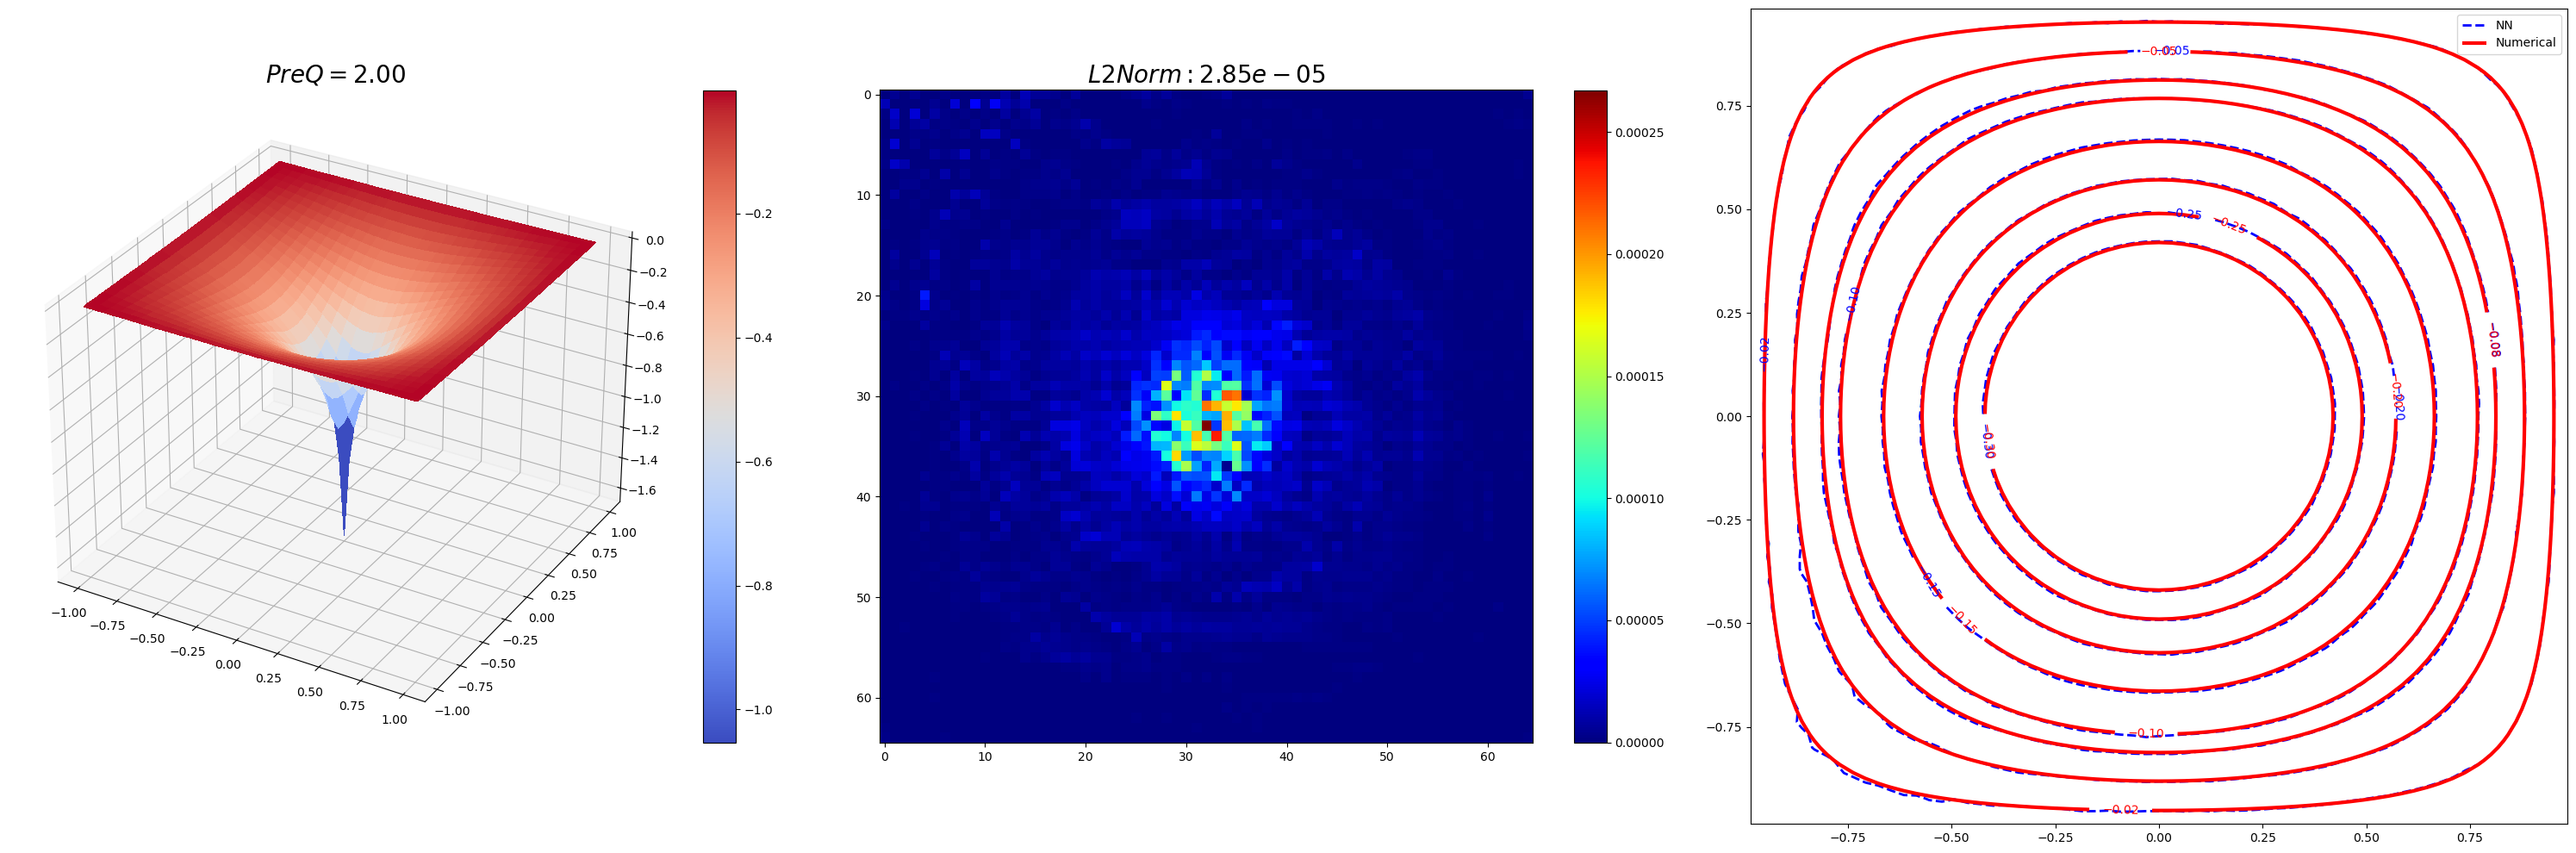

In [32]:
def validate(model, ckpt_path, data_path, levels,a=1, N=131, data_type='One', boundary_type='D', numerical_method='fd'):
    
    A = sparse.load_npz(f'{data_path}/{N}/mat/{numerical_method}_A{boundary_type}.npz').tocsr()
    valB = np.load(f'{data_path}/{N}/{data_type}/{numerical_method}_ValB.npy')
    data = np.load(f'{data_path}/{N}/{data_type}/{numerical_method}_ValF.npy')
    
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()

    if numerical_method == 'fd':
        x = np.linspace(-a, a, N)
        y = np.linspace(-a, a, N)
    elif numerical_method == 'fv':
        x = np.linspace(-a+h/2, a-h/2, N)
        y = np.linspace(-a+h/2, a-h/2, N)
        
    xx, yy = np.meshgrid(x, y)
    
    num = data.shape[0]
    Qs = np.linspace(1, 2, num) if not 'Big' in data_path else \
         np.linspace(10000, 20000, num)
    
    for i in range(10):
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(30)
        
        tensor = np.stack([xx, yy, data[i]], axis=0)
        tensor = torch.from_numpy(tensor[np.newaxis, ...]).to(dtype=torch.float32)
        pre = model.padder(model(tensor))
        pre = pre.squeeze().numpy()
        ans = spsolve(A, valB[i]).reshape(N, N)
        
        diff = (pre - ans)**2
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax1.set_title(f'$Pre Q={Qs[i]:.2f}$', fontsize=20)
        plt.colorbar(surf_pre, ax=ax1, shrink=0.8)
        
        im = ax2.imshow(diff, cmap='jet')   
        plt.colorbar(im, ax=ax2, shrink=0.8)
        ax2.set_title(f'$L2 Norm:{(diff*h**2).sum():.2e}$', fontsize=20)
        
        ct1 = ax3.contour(xx, yy, pre, colors='b', linewidths=2, linestyles='dashed', levels=levels)
        ct2 = ax3.contour(xx, yy, ans, colors='r', linewidths=3, linestyles='solid', levels=levels)
        ax3.clabel(ct1, inline=True, fontsize=10)
        ax3.clabel(ct2, inline=True, fontsize=10)
        h1, _ = ct1.legend_elements()
        h2, _ = ct2.legend_elements()
        ax3.legend([h1[0], h2[0]], ['NN', 'Numerical'],  fontsize='medium')
        
        fig.tight_layout()

bd = 'D'
N = 65
a = 1
h = 2*a / N
data_type='One'
backward_type = 'cg'
numerical_method = 'fv'
features = 32
batch_size = 32

# model = LAModel(net = myUNet(layers=[1, 2, 4, 8, 16], features=features, boundary_type=bd, numerical_method=numerical_method), 
#                 data_path=f'../data/{datatype}{N}/', boundary_type=bd, h=h, numerical_method=numerical_method)

model = LAModel(net = UNet(features=features, boundary_type=bd, numerical_method=numerical_method), 
                data_path=f'../data/{N}/mat/', boundary_type=bd, h=h, numerical_method=numerical_method)

validate(model, ckpt_path=f'../lightning_logs/{numerical_method}_{backward_type}_{N}_UNet_{features}_bs{batch_size}_{data_type}{bd}/version_0/checkpoints/last.ckpt', 
             data_path = f'../data/', N=N, a=a, boundary_type=bd, data_type = data_type,
             levels=levels2, numerical_method=numerical_method)

In [ ]:
def test_qs(model, ckpt_path, Qs, func, name, label, order=2, N=131, mode='F', title=''):
    
    h = 2/(N-1)
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()

    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    xx, yy = np.meshgrid(x, y)
    X = np.stack((xx, yy))
    mask = np.ones_like(xx)
    mask[1:-1, 1:-1] *= 0
    delta = func(xx, yy, h)
    
    im_nums = len(Qs)
    if title == '':
        A = fd_A(N).tocsr()
        xx = xx[1:-1, 1:-1]
        yy = yy[1:-1, 1:-1]
        
    elif title == 'neu':
        A = fd_A_neu(N).tocsr()
    elif title == 'bc':
        A = fd_A_with_bc(N).tocsr()
        
    for idx, Q in enumerate(Qs):
        fig1 = plt.figure()
        fig1.set_figheight(10)
        fig1.set_figwidth(10)

        fig2 = plt.figure()
        fig2.set_figheight(10)
        fig2.set_figwidth(10)

        fig3 = plt.figure()
        fig3.set_figheight(10)
        fig3.set_figwidth(10)

        ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
        ax2 = fig2.add_subplot(1, 1, 1)
        ax3 = fig3.add_subplot(1, 1, 1)
        ax2.set_aspect('equal', 'box')
        ax2.set_axis_off()
        ax3.set_aspect('equal', 'box')
        
        if mode == 'F':
            data = torch.from_numpy(np.stack((*X, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)
        elif mode == 'M':
            data = torch.from_numpy(np.stack((mask, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)
        pre = model(data).squeeze().numpy()
        
        if title == '':
            b = fd_b(Q * delta, h)
            ans = spsolve(A, b).reshape(N-2, N-2)       
        elif title == 'neu' or title == 'bc':
            b = fd_b_bc(Q * delta, h)
            ans = spsolve(A, b).reshape(N, N)    
        
        diff = (pre - ans)**2

        surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)    
        ax1.set_title(f'Q={Q:.2f}  {label}', fontsize=30)
        ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        plt.colorbar(surf_pre, ax=ax1, shrink=0.8)
        
        im = ax2.imshow(diff, cmap='jet')   
        plt.colorbar(im, ax=ax2, shrink=0.8)
        ax2.set_title(f'Q={Q:.2f}  {label}  L2:{(diff*h**2).sum():.1e}', fontsize=30)
        ct1 = ax3.contour(xx, yy, pre, colors='b', linewidths=2,linestyles='solid')
        ct2 = ax3.contour(xx, yy, ans, colors='r', linewidths=4, linestyles='solid')    
        
        ax3.clabel(ct1, inline=True, fontsize=23)
        ax3.clabel(ct2, inline=True, fontsize=23)
        h1, _ = ct1.legend_elements()
        h2, _ = ct2.legend_elements()
        ax3.legend([h1[0], h2[0]], ['NN', 'Numerical'], prop={'size':23})
        ax3.set_title(f'Q={Q:.2f}  {label}', fontsize=30)
        
        
        fig1.tight_layout()
        fig2.tight_layout()
        fig3.tight_layout()
        
        fig1_name = f'surface_q{Q}_{name}'
        fig2_name = f'im_q{Q}_{name}'
        fig3_name = f'contour_q{Q}_{name}'
        
        fig1.savefig(f'./images/{fig1_name}.png', format='png',transparent=True)
        fig2.savefig(f'./images/{fig2_name}.png', format='png',transparent=True)
        fig3.savefig(f'./images/{fig3_name}.png', format='png',transparent=True)
        
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    return 

model = LAModel(net = UNet(3, 1, 16, 'D'),data_path='../data/One129/', boundary_type='D')

test_qs(model, 
        ckpt_path='../lightning_logs/cg_F_129_UNet_16_bs8_OneD/version_0/checkpoints/last.ckpt',
        Qs=[0.62, 0.74, 0.88, 0.96, 1.23, 1.45, 1.67, 1.92, 2.12, 2.34, 2.56, 2.73], func=normal, order=2, N=129, mode='F', name='neu_F_33_UNet_16_bs8_energy', label='Energy', title='neu')



In [ ]:
names = ['Energy', 'Jacobian', 'MSE']
def test_models(model, ckpt_paths, Q, func, N=131, mode='F', bc=False):
    num = len(ckpt_paths)
    h = 2/(N-1)
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    xx, yy = np.meshgrid(x, y)
    
    mask = np.ones_like(xx)
    mask[1:-1, 1:-1] *= 0
    delta = func(xx, yy, h)

    width = num * 10
    height = 10
    
    fig1 = plt.figure()
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    
    fig2 = plt.figure()
    fig2.set_figheight(height)
    fig2.set_figwidth(width)
    
    fig3 = plt.figure()
    fig3.set_figheight(height)
    fig3.set_figwidth(width)

    if mode == 'F':
        data = torch.from_numpy(np.stack((xx, yy, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)
    elif mode == 'M':
        data = torch.from_numpy(np.stack((mask, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)

    A = fd_A(N, 2).tocsr()
    b = fd_b(Q * delta, h, 2)
    ans = spsolve(A, b).reshape(N-2, N-2)
    
    for idx, ckpt_path in enumerate(ckpt_paths):
        ckpt = torch.load(ckpt_path)
        model.load_state_dict(ckpt['state_dict'])
        model.freeze()
        pre = model(data).squeeze().numpy()
        diff = (pre - ans)**2
        
        ax1 = fig1.add_subplot(1, num, idx + 1, projection='3d')
        ax2 = fig2.add_subplot(1, num, idx + 1)
        ax3 = fig3.add_subplot(1, num, idx + 1)
        
#         ax1.set_aspect('equal', 'box')
        ax2.set_aspect('equal', 'box')
        ax3.set_aspect('equal', 'box')

        if bc:
            surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        else:
            surf_pre = ax1.plot_surface(xx[1:-1, 1:-1], yy[1:-1, 1:-1], pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
            
        ax1.set_title(f'Q={Q:.2f}  {names[idx]}', fontsize=25)
        plt.colorbar(surf_pre, ax=ax1, shrink=0.6)
        
        im = ax2.imshow(diff, cmap='jet')   
#         ct = ax2.contourf(xx[1:-1, 1:-1], yy[1:-1, 1:-1], diff, cmap='jet')
        plt.colorbar(im, ax=ax2, shrink=0.8)
        ax2.set_title(f'Q={Q:.2f}  {names[idx]}  L2:{(diff*h**2).sum():.1e}', fontsize=20)
        ax2.set_axis_off()
        if bc:
            ct1 = ax3.contour(xx, yy, pre, colors='b', linewidths=2)
            ct2 = ax3.contour(xx, yy, ans, colors='r', linewidths=3, linestyles='solid',)
        else:
            ct1 = ax3.contour(xx[1:-1, 1:-1], yy[1:-1, 1:-1], pre, colors='b', linewidths=2)
            ct2 = ax3.contour(xx[1:-1, 1:-1], yy[1:-1, 1:-1], ans, colors='r', linewidths=3, linestyles='solid',)
        ax3.set_title(f'Q={Q:.2f}  {names[idx]}', fontsize=35)
        ax3.clabel(ct1, inline=True, fontsize=18)
        ax3.clabel(ct2, inline=True, fontsize=18)
        h1, _ = ct1.legend_elements()
        h2, _ = ct2.legend_elements()
        ax3.legend([h1[0], h2[0]], ['NN', 'Numerical'], prop={'size':25})
        
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    
model = pl_Model(net = UNet(3, 1, 16, False),
              loss = F.l1_loss,
              data_path='./data/normal33/')
test_models(model, 
            ckpt_paths=[
                './lightning_logs/F_33_UNet_16_bs8_energy_order2_lr1e-03/version_0/checkpoints/last.ckpt',
                './lightning_logs/F_33_UNet_16_bs8_jac_order2_lr1e-03/version_0/checkpoints/last.ckpt',
                './lightning_logs/F_33_UNet_16_bs8_mse_lr1e-03/version_0/checkpoints/last.ckpt'
            ],            Q=1.8, func=normal, N=33, mode='F')

In [ ]:
def test_with_fine_result(model, ckpt_path, test_data_path, func, order=2, N=131, mode='F'):
    
    p = Path(test_data_path)
    
    
    h = 2/(N-1)
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()

    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    xx, yy = np.meshgrid(x, y)
    
    mask = np.ones_like(xx)
    mask[1:-1, 1:-1] *= 0
    delta = func(xx, yy, h)
    
    for fine_u in p.iterdir():
        Q = float(fine_u.name[:4])
        ans = np.load(fine_u)
        n = int(np.sqrt(ans.shape))
        xg, yg = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
        X, Y = np.meshgrid(xg, yg)
#         func_cu = RegularGridInterpolator((xg, yg), ans.reshape(n, n))
#         ans = func_cu((xx, yy)).reshape(N, N)[1:-1, 1:-1]
        
        if mode == 'F':
            data = torch.from_numpy(np.stack((xx, yy, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)
            pre = model(data).squeeze().numpy()
    
        elif mode == 'M':
            data = torch.from_numpy(np.stack((mask, Q * delta))[np.newaxis, ...]).to(dtype=torch.float32)
            pre = model(data).squeeze().numpy()
     
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(30)

#         diff = (pre - ans)**2
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#         ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        surf_pre = ax1.plot_surface(xx[1:-1, 1:-1], yy[1:-1, 1:-1], pre, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax1.set_title(f'$Pre Q={Q:.4f}$', fontsize=20)
        plt.colorbar(surf_pre, ax=ax1, shrink=0.8)
        
        
#         im = ax2.imshow(diff, cmap='jet')   
#         plt.colorbar(im, ax=ax2, shrink=0.8)
#         ax2.set_title(f'$L2 Norm:{(diff*h**2).sum():.4f}$', fontsize=20)
        
        
        ct1 = ax3.contour(xx[1:-1, 1:-1], yy[1:-1, 1:-1], pre, colors='b', linewidths=2)
        ct2 = ax3.contour(X, Y, ans.reshape(X.shape), colors='r', linewidths=3, linestyles='solid')
        ax3.clabel(ct1, inline=True, fontsize=10)
        ax3.clabel(ct2, inline=True, fontsize=10)
        h1, _ = ct1.legend_elements()
        h2, _ = ct2.legend_elements()
        ax3.legend([h1[0], h2[0]], ['NN', 'Numerical'],  fontsize='medium')
        
        fig.tight_layout()

model = pl_Model(net = UNet(3, 1, 16, False),
              loss = F.l1_loss,
              val_save_path='./valu/nouse/',
              data_path='./data/normal65/',
              lr=1e-3, order=2)
test_with_fine_result(model, ckpt_path='./lightning_logs/F_65_UNet_16_bs16_jac_order2_lr1e-03/version_0/checkpoints/epoch=62-step=7875.ckpt', 
        test_data_path='./data/test/', func=normal1, order=2, N=65, mode='F')

In [5]:
ckpt_path = '../lightning_logs/fv_cg_65_UNet_32_bs32_OneD/version_1/checkpoints/last.ckpt'
ckpt = torch.load(ckpt_path)
print(ckpt.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
